In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('tableau-colorblind10')
import scipy.stats as sps
import networkx as nx
import time
from Dist_KL_UCB import Dist_KL_UCB
from KL_UCB import KL_UCB
from Dist_UCB1 import Dist_UCB1

n_runs = 100
T = 10000
N = 25
rwd_means = [.2, .3, .4, .5, .6]

seeds = []
myseed = 0
while len(seeds) < n_runs:
    G = nx.fast_gnp_random_graph(N, 0.5, directed=False, seed=myseed)
    if nx.is_connected(G):
        seeds.append(myseed)
    myseed += 1

kl_distributions = [sps.beta(rwd_means[i], 1-rwd_means[i]) for i in range(len(rwd_means))]
for i in range(len(rwd_means)):
    kl_distributions[i].random_state = np.random.RandomState(seed=1)
distributions = [[sps.beta(rwd_means[i], 1-rwd_means[i]) for i in range(len(rwd_means))] for n in range(N)]
for n in range(N):
    for i in range(len(rwd_means)):
        distributions[n][i].random_state = np.random.RandomState(seed=1)
sigmas = [1, .1, .01]

In [ ]:
mean_regrets_dist_kl_ucb = np.zeros((n_runs, len(sigmas), T))
regrets_kl_ucb = np.zeros((n_runs, T))
init_time = time.time()
for run in range(n_runs):
    start_run_t = time.time()
    G = nx.fast_gnp_random_graph(N, 0.5, directed=False, seed=seeds[run])
    nodes = list(G.nodes)
    for i in nodes:
        G.add_edge(i,i) 
    for sig in range(len(sigmas)):
        distkl = Dist_KL_UCB(T, distributions, G, sigma=sigmas[sig])
        distkl.run()
        mean_regrets_dist_kl_ucb[run, sig, :] = np.mean(distkl.regrets, axis=0)

    kl = KL_UCB(T, kl_distributions)
    kl.run()
    regrets_kl_ucb[run, :] = kl.regret
    end_run_t = time.time()
    print(f'finished run {run} in {end_run_t - start_run_t}sec')

time_axis = list(range(distkl.T))
mean_regrets_over_all_runs_dist_kl_ucb = np.mean(mean_regrets_dist_kl_ucb, axis=0)
mean_regrets_over_all_runs_kl_ucb = np.mean(regrets_kl_ucb, axis=0)
std_regrets_over_all_runs_dist_kl_ucb = np.std(mean_regrets_dist_kl_ucb, axis=0)
std_regrets_over_all_runs_kl_ucb = np.std(regrets_kl_ucb, axis=0)
print(f'Total run time = {end_run_t - init_time}sec')

finished run 0 in 904.4171905517578sec


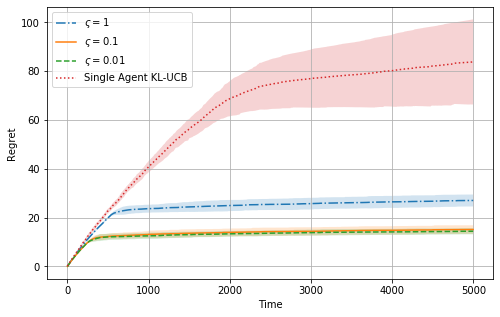

In [35]:
plt.figure(figsize=(8,5))
linestyles = ['-.', '-', '--']
for sig in range(len(sigmas)):
    plt.plot(time_axis, mean_regrets_over_all_runs_dist_kl_ucb[sig], linestyles[sig], label=r"$\varsigma=$" + str(sigmas[sig]))
    plt.fill_between(time_axis, mean_regrets_over_all_runs_dist_kl_ucb[sig]-std_regrets_over_all_runs_dist_kl_ucb[sig], mean_regrets_over_all_runs_dist_kl_ucb[sig]+std_regrets_over_all_runs_dist_kl_ucb[sig],alpha=.2)
plt.plot(time_axis, mean_regrets_over_all_runs_kl_ucb, ':', label="Single Agent KL-UCB")
plt.fill_between(time_axis, mean_regrets_over_all_runs_kl_ucb-std_regrets_over_all_runs_kl_ucb, mean_regrets_over_all_runs_kl_ucb+std_regrets_over_all_runs_kl_ucb, alpha=.2)
plt.xlabel("Time")
plt.ylabel("Regret")
plt.legend()
plt.grid()
plt.savefig("./.out/dist_KL_vs_single_KL.pdf", bbox_inches='tight')